In [5]:
# !pip install scipy


In [6]:
from scipy.io import loadmat
annots = loadmat('dataset_liver_bmodes_steatosis_assessment_IJCARS.mat')

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

# Display one scan

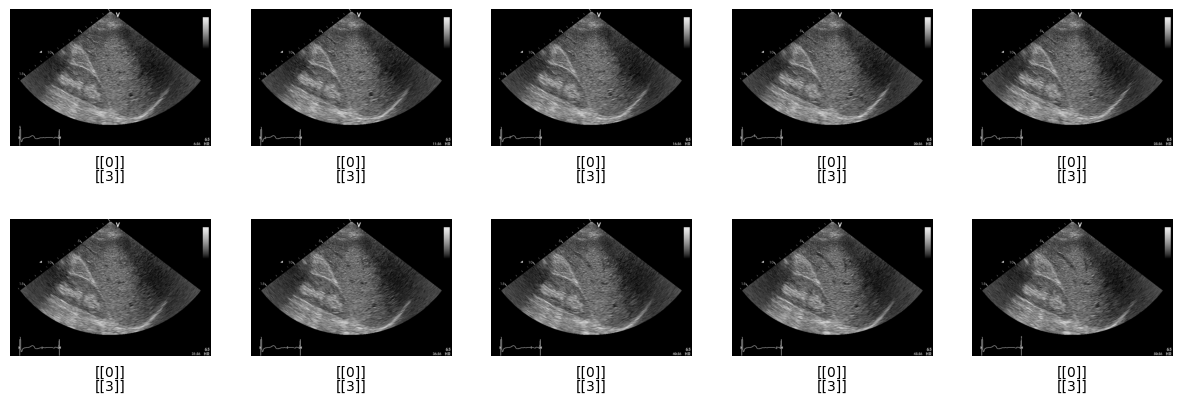

In [9]:
# Display the 1 person's scan
images = annots['data']['images'][0][0]

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')
    ax.text(0.5, -0.15, annots['data']['class'][0][0], fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.25, annots['data']['fat'][0][0], fontsize=10, ha='center', transform=ax.transAxes)

plt.show()

# Display sample ultrasound scans

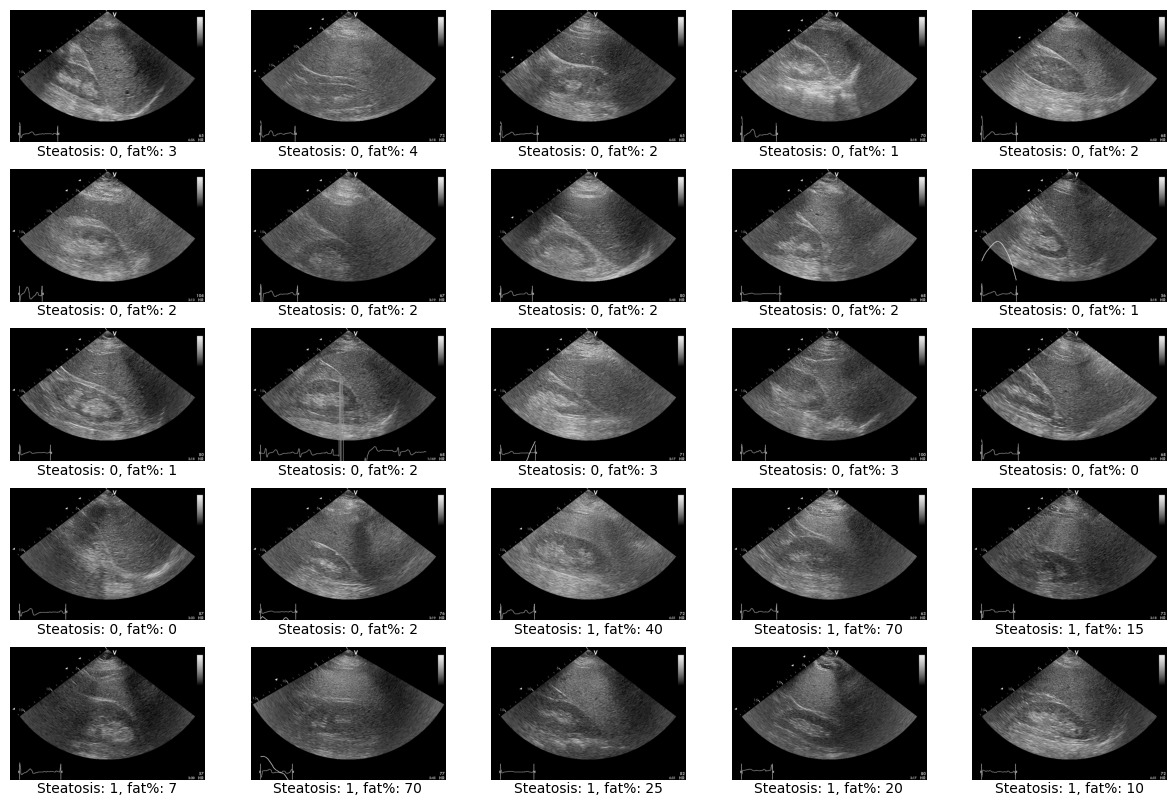

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    images = annots['data']['images'][0][i]

    
    ax.imshow(images[0], cmap='gray')
    ax.axis('off')
    ax.text(0.5, -0.1,f"Steatosis: {annots['data']['class'][0][i][0][0]}, fat%: {annots['data']['fat'][0][i][0][0]}", fontsize=10, ha='center', transform=ax.transAxes)

plt.show()

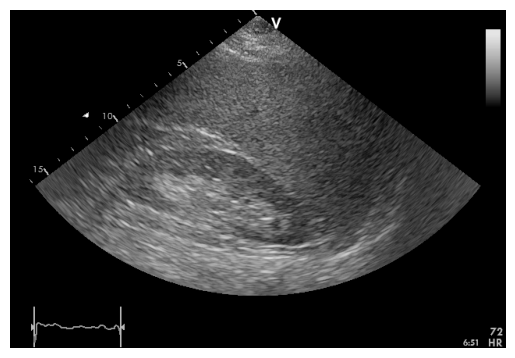

In [18]:
image = annots['data']['images'][0][24][0]
image = image.astype('uint8')

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

## Histograms - scaled and unscaled

<Axes: title={'center': 'Image pixel distribution'}, ylabel='Frequency'>

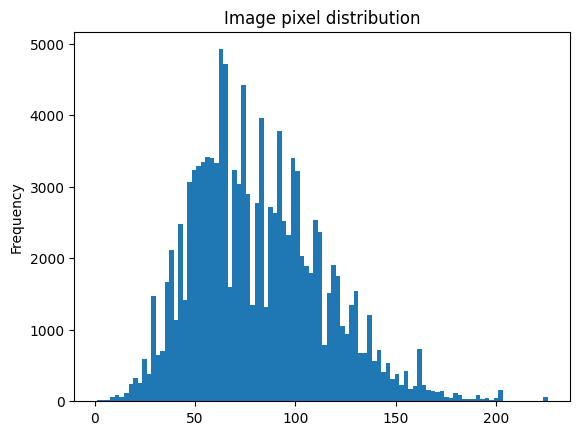

In [19]:
non_zero_values = image.flatten()[image.flatten() != 0]

pd.Series(non_zero_values).plot(kind="hist", bins=100, title="Image pixel distribution")


<Axes: title={'center': 'Scaled image pixel distribution'}, ylabel='Frequency'>

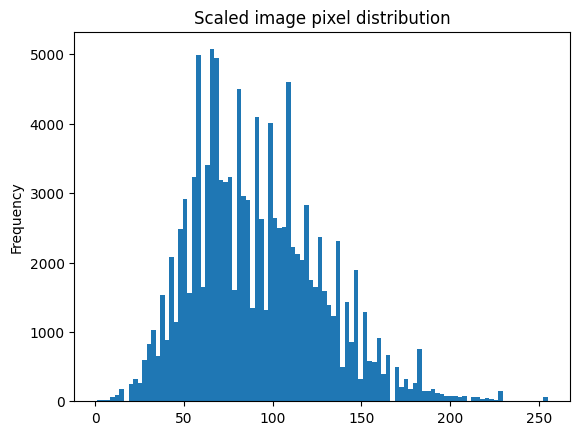

In [20]:
image_scaled = (image / np.max(image)) * 255
image_scaled =image_scaled.astype(np.uint8)


non_zero_values = image_scaled.flatten()[image_scaled.flatten() != 0]
pd.Series(non_zero_values).plot(kind="hist", bins=100, title="Scaled image pixel distribution")

In [21]:
def enhance_image(image):

    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)
    
    # Apply histogram equalization to enhance contrast
    enhanced_image = cv2.equalizeHist(scaled_image)
    
    # Apply Gaussian blur to reduce noise
    enhanced_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)
    
    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))
    normalized_image = cv2.normalize(sharpened_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return normalized_image


In [22]:
def enhancer_image(image):
    image = np.uint8(image)
    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)
    
    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))
    
    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)
    
    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))
    normalized_image = cv2.normalize(sharpened_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return normalized_image


In [23]:
def show_img(label, image):
    # image = image.astype(np.uint8)

    cv2.imshow(label, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

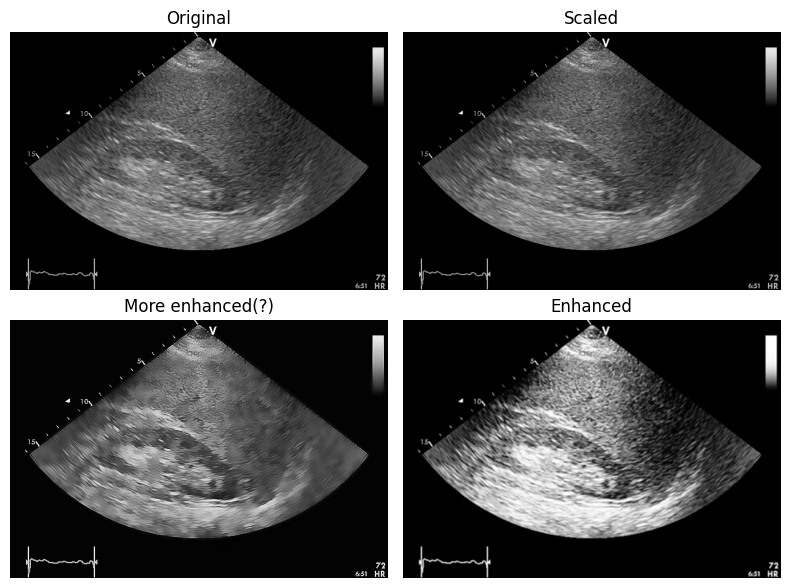

In [24]:
enhanced_img1 = enhance_image(image)
enhanced_img2 = enhancer_image(image_scaled)

plt.figure(figsize=(8,6))

# Plot first image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')
plt.axis('off')

# Plot second image
plt.subplot(2, 2, 2)
plt.imshow(image_scaled, cmap='gray')
plt.title('Scaled')
plt.axis('off')

# Plot third image
plt.subplot(2, 2, 3)
plt.imshow(enhanced_img2, cmap='gray')
plt.title('More enhanced(?)')
plt.axis('off')

# Plot fourth image
plt.subplot(2, 2, 4)
plt.imshow(enhanced_img1, cmap='gray')
plt.title('Enhanced')
plt.axis('off')

plt.tight_layout() 
plt.show()


## Full fledged code:

In [151]:
data = annots['data']

for record in range(0, 55):
    id = data['id'][0][record][0][0]
    # id will alwys be record+1; record starts from 0, id from 1

    imgs = (data['images'][0][record])
    counter = 0
    for im in imgs:
        filename = f"{id}_{data['class'][0][record][0][0]}_{data['fat'][0][record][0][0]}_{counter}.jpg"
        counter += 1
        enh_im = enhance_image(im.astype(np.uint8))
        enh_im1 = enhancer_image(im.astype(np.uint8))
        roi_im = enh_im[120:350, 125:420]


        plt.imsave(f"og/{filename}", im.astype(np.uint8),cmap="grey" )
        plt.imsave(f"enh/{filename}", enh_im, cmap="grey" )
        plt.imsave(f"roi/{filename}", roi_im, cmap="grey" )




(434, 636)


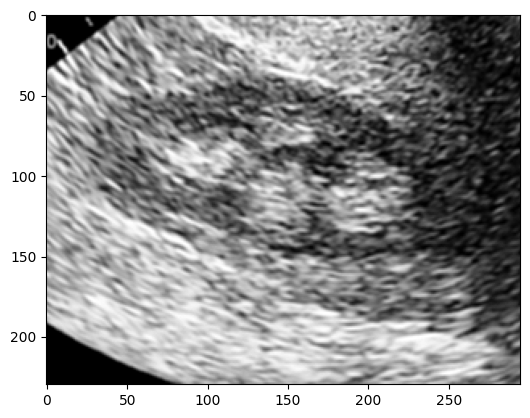

In [150]:
dum_im = enh_im

print(dum_im.shape)
dum_im = dum_im[120:350, 125:420]

plt.imshow(dum_im, cmap='gray')
plt.imsave(f"roi/{filename}", dum_im, cmap="grey" )
